In [1]:
import os
from dotenv import load_dotenv

load_dotenv(override=True)
OPENAI_API_KEY = os.environ["OPENAI_API_KEY"]

In [2]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(
    model="gpt-4o-mini",
    temperature=0,
    api_key=OPENAI_API_KEY
)

In [3]:
from langchain_openai import OpenAIEmbeddings
from langchain_community.vectorstores import FAISS

embeddings = OpenAIEmbeddings(api_key=OPENAI_API_KEY)

memory_store = FAISS.from_texts(
    texts=["Initial memory placeholder"],
    embedding=embeddings
)

In [4]:
from typing import TypedDict, List

class MemoryState(TypedDict):
    question: str
    retrieved_memories: List[str]
    answer: str

In [5]:
def memory_read_node(state: MemoryState) -> MemoryState:
    docs = memory_store.similarity_search(state["question"], k=2)
    memories = [doc.page_content for doc in docs]

    return {
        **state,
        "retrieved_memories": memories
    }

In [6]:
def generate_node(state: MemoryState) -> MemoryState:
    memory_text = "\n".join(state["retrieved_memories"])

    prompt = f"""
Use the past experiences below to help answer the question.

Past memories:
{memory_text}

Question:
{state['question']}
"""

    response = llm.invoke(prompt)

    return {
        **state,
        "answer": response.content
    }

In [7]:
def memory_write_node(state: MemoryState) -> MemoryState:
    experience = f"Q: {state['question']}\nA: {state['answer']}"
    memory_store.add_texts([experience])

    return state

In [8]:
from langgraph.graph import StateGraph, END

graph = StateGraph(MemoryState)

graph.add_node("read_memory", memory_read_node)
graph.add_node("generate", generate_node)
graph.add_node("write_memory", memory_write_node)

graph.set_entry_point("read_memory")

graph.add_edge("read_memory", "generate")
graph.add_edge("generate", "write_memory")
graph.add_edge("write_memory", END)

app = graph.compile()

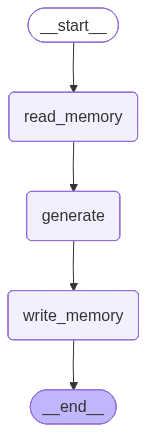

In [9]:
from IPython.display import Image, display

display(Image(app.get_graph().draw_mermaid_png()))

In [12]:
question = "is gold a good investment ?"

initial_state: MemoryState = {
    "question": question,
    "retrieved_memories": [],
    "answer": ""
}

final_state = app.invoke(initial_state)

print("\nAnswer:\n")
print(final_state["answer"])



Answer:

Gold has historically been considered a good investment for several reasons:

1. **Hedge Against Inflation**: Gold often retains its value over time, making it a popular choice during periods of inflation when the purchasing power of currency declines.

2. **Safe Haven Asset**: During times of economic uncertainty or geopolitical instability, investors tend to flock to gold as a safe haven, which can drive up its price.

3. **Diversification**: Including gold in an investment portfolio can provide diversification, as it often behaves differently than stocks and bonds.

4. **Tangible Asset**: Unlike stocks or bonds, gold is a physical asset that can be held and stored, which some investors find appealing.

However, there are also considerations to keep in mind:

1. **Volatility**: While gold can be a safe haven, its price can be volatile in the short term, influenced by market sentiment, currency fluctuations, and changes in interest rates.

2. **No Income Generation**: Gold d

In [14]:
final_state = app.invoke({"question": "can we invest in gold or stocks?"})

print("\nAnswer:\n")
print(final_state["answer"])


Answer:

Yes, you can invest in both gold and stocks, and each has its own advantages and considerations. 

### Investing in Gold:
- **Hedge Against Inflation**: Gold can help protect your purchasing power during inflationary periods.
- **Safe Haven Asset**: It tends to retain value during economic uncertainty, making it a popular choice for risk-averse investors.
- **Diversification**: Including gold in your portfolio can provide diversification, as it often behaves differently than stocks and bonds.

### Investing in Stocks:
- **Growth Potential**: Stocks have the potential for significant capital appreciation over time, especially if you invest in high-growth companies or sectors.
- **Income Generation**: Many stocks pay dividends, providing a source of income in addition to potential price appreciation.
- **Variety of Options**: You can invest in individual companies, ETFs, or mutual funds, allowing for a range of strategies and risk levels.

### Considerations:
- **Risk Tolerance